In [39]:
import os
import torch
import json
from torch.utils.data import DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from data import load_data
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from util import cross_entropy_loss_fn, plot_samples
import numpy as np
from precision_recall import prd_score
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import re
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_dir_vanilla = 'results_made/20240718_203150_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.0_PAT10_MOD/'
result_dir_aug = 'results_made/20240808_164412_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM-1.0_PAT10_AUG_MOD/'
result_dir_reg = 'results_made/20240718_210453_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.1_PAT10_MOD/'
result_dir_reg_plus = 'results_made/20240718_230620_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM1.0_PAT10_MOD/'

model_vanilla = torch.load(result_dir_vanilla + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_vanilla.eval()
with open(result_dir_vanilla + 'evaluate_results.json', 'r') as file:
    eval_dic_vanilla = json.load(file)

model_aug = torch.load(result_dir_aug + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_aug.eval()
with open(result_dir_aug + 'evaluate_results.json', 'r') as file:
    eval_dic_aug = json.load(file)

model_reg = torch.load(result_dir_reg + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_reg.eval()
with open(result_dir_reg + 'evaluate_results.json', 'r') as file:
    eval_dic_reg = json.load(file)

model_reg_plus = torch.load(result_dir_reg_plus + 'model_best.model', map_location=torch.device('cpu')).to(device)
model_reg_plus.eval()
with open(result_dir_reg_plus + 'evaluate_results.json', 'r') as file:
    eval_dic_reg_plus = json.load(file)

In [29]:
from util import compute_nlls, sample_model
x_vanilla = sample_model(model_vanilla, n = 1000, model_type = 'MADE')
dim = x_vanilla.shape[1] * x_vanilla.shape[2] * x_vanilla.shape[3]
samples_vanilla = [(x_vanilla[i].reshape(1,-1), 0) for i in range(len(x_vanilla))]
data_loader_vanilla = DataLoader(samples_vanilla,  batch_size=1)
nlls_vanilla = compute_nlls(model_vanilla, data_loader=data_loader_vanilla, model_type = 'MADE').tolist()

x_aug = sample_model(model_aug, n = 1000, model_type = 'MADE')
dim = x_aug.shape[1] * x_aug.shape[2] * x_aug.shape[3]
samples_aug = [(x_aug[i].reshape(1,-1), 0) for i in range(len(x_aug))]
data_loader_aug = DataLoader(samples_aug,  batch_size=1)
nlls_aug = compute_nlls(model_aug, data_loader=data_loader_aug, model_type = 'MADE').tolist()

x_reg = sample_model(model_reg, n = 1000, model_type = 'MADE')
dim = x_reg.shape[1] * x_reg.shape[2] * x_reg.shape[3]
samples_reg = [(x_reg[i].reshape(1,-1), 0) for i in range(len(x_reg))]
data_loader_reg = DataLoader(samples_reg,  batch_size=1)
nlls_reg = compute_nlls(model_reg, data_loader=data_loader_reg, model_type = 'MADE').tolist()

x_reg_plus = sample_model(model_reg_plus, n = 1000, model_type = 'MADE')
dim = x_reg_plus.shape[1] * x_reg_plus.shape[2] * x_reg_plus.shape[3]
samples_reg_plus = [(x_reg_plus[i].reshape(1,-1), 0) for i in range(len(x_reg_plus))]
data_loader_reg_plus = DataLoader(samples_reg_plus,  batch_size=1)
nlls_reg_plus = compute_nlls(model_reg_plus, data_loader=data_loader_reg_plus, model_type = 'MADE').tolist()

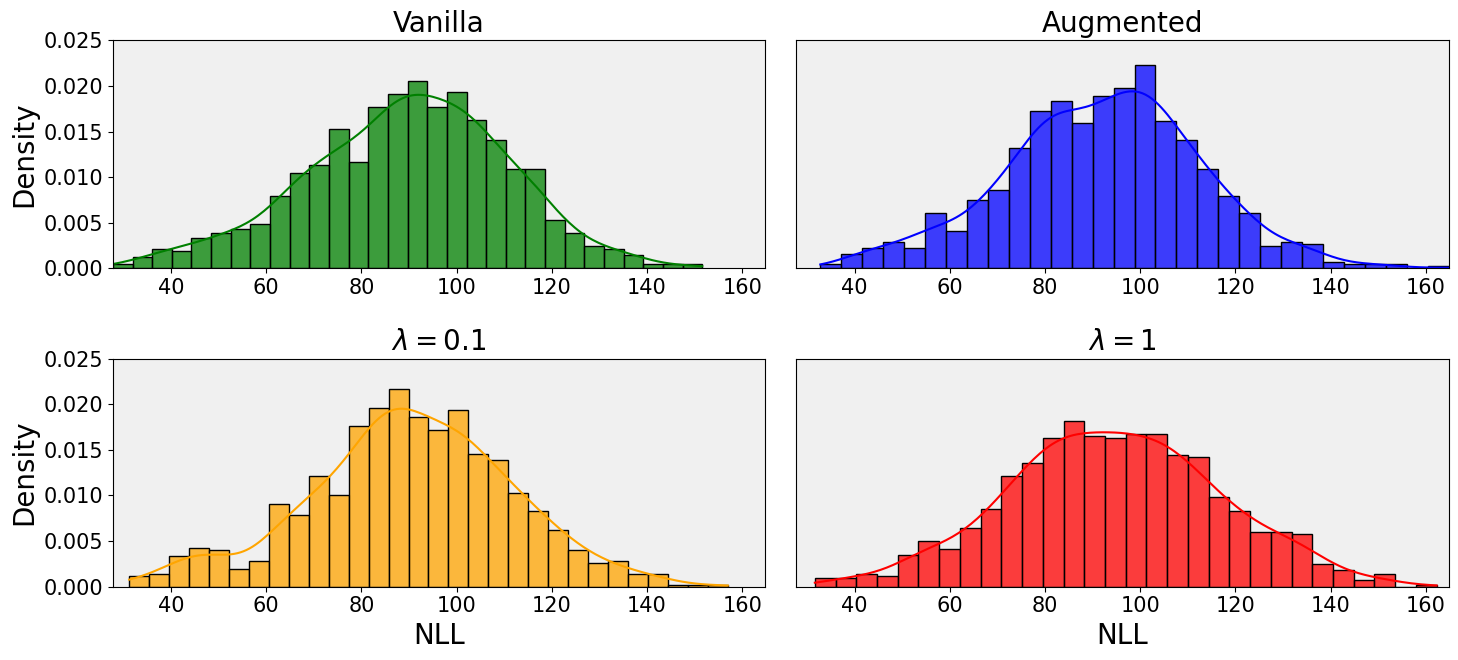

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure with updated size
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

# Calculate the limits based on your data
x_min = min(np.min(nlls_vanilla), np.min(nlls_aug), np.min(nlls_reg), np.min(nlls_reg_plus))
x_max = max(np.max(nlls_vanilla), np.max(nlls_aug), np.max(nlls_reg), np.max(nlls_reg_plus))

# Set the same y-limits after plotting
y_min = 0  # Since we're plotting densities, the minimum y-value should be 0.
y_max = 0.025

# Plot for Vanilla
sns.histplot(np.array(nlls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][0], label='Vanilla')
axs[0][0].set_title('Vanilla')
axs[0][0].set_xlabel('')
axs[0][0].set_ylabel('Density')
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].set_xlim(x_min, x_max)
axs[0][0].set_ylim(y_min, y_max)
axs[0][0].grid(False)  # Remove the grid

# Plot for Augmented
sns.histplot(np.array(nlls_aug), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs[0][1], label='Augmented')
axs[0][1].set_title('Augmented')
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].set_xlim(x_min, x_max)
axs[0][1].set_ylim(y_min, y_max)
axs[0][1].set_yticks([])  # Hide y-axis ticks
axs[0][1].set_ylabel('')   # Remove y-axis label
axs[0][1].set_xlabel('')
axs[0][1].grid(False)  # Remove the grid

# Plot for Regularized (lambda = 0.1)
sns.histplot(np.array(nlls_reg), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs[1][0], label=r'$\lambda=0.1$')
axs[1][0].set_title(r'$\lambda = 0.1$')
axs[1][0].set_xlabel('NLL')
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].set_xlim(x_min, x_max)
axs[1][0].set_ylim(y_min, y_max)
axs[1][0].set_ylabel('Density')
axs[1][0].grid(False)  # Remove the grid

# Plot for Regularized (lambda = 1)
sns.histplot(np.array(nlls_reg_plus), bins=30, stat='density', kde=True, color='red', alpha=0.75, ax=axs[1][1], label=r'$\lambda=1$')
axs[1][1].set_title(r'$\lambda = 1$')
axs[1][1].set_xlabel('NLL')
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].set_xlim(x_min, x_max)
axs[1][1].set_ylim(y_min, y_max)
axs[1][1].set_yticks([])  # Hide y-axis ticks
axs[1][1].set_ylabel('')   # Remove y-axis label
axs[1][1].grid(False)  # Remove the grid

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('images/made/samples_made_hist.pdf', format='pdf', bbox_inches='tight')
plt.show()


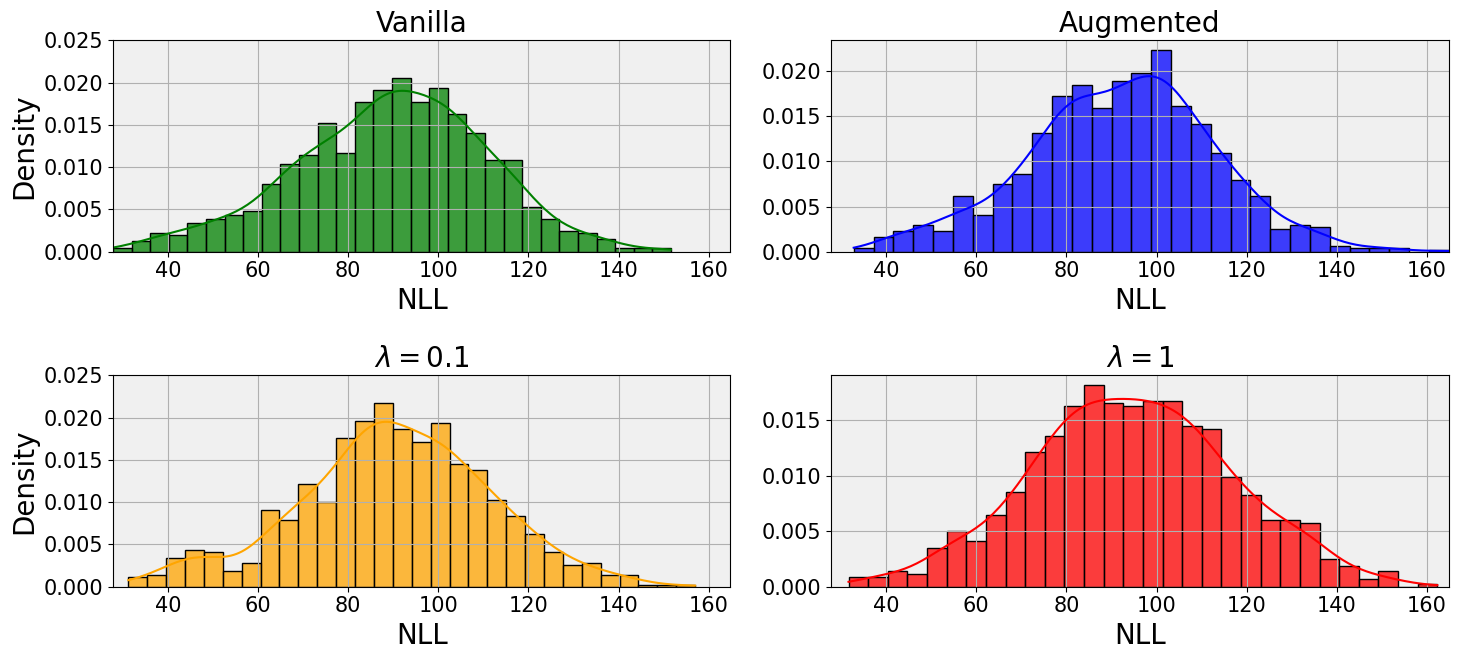

In [44]:
# Create the figure with updated size
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

# Calculate the limits based on your data
x_min = min(np.min(nlls_vanilla), np.min(nlls_aug), np.min(nlls_reg), np.min(nlls_reg_plus))
x_max = max(np.max(nlls_vanilla), np.max(nlls_aug), np.max(nlls_reg), np.max(nlls_reg_plus))

# Set the same y-limits after plotting
y_min = 0  # Since we're plotting densities, the minimum y-value should be 0.
y_max = 0.025

# Plot for Vanilla
sns.histplot(np.array(nlls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][0], label='Vanilla')
axs[0][0].set_title('Vanilla')
axs[0][0].set_xlabel('NLL')
axs[0][0].set_ylabel('Density')
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].grid(True)
axs[0][0].set_xlim(x_min, x_max)
axs[0][0].set_ylim(y_min, y_max)

# Plot for Augmented
sns.histplot(np.array(nlls_aug), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs[0][1], label='Augmented')
axs[0][1].set_title('Augmented')
axs[0][1].set_xlabel('NLL')
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].grid(True)
axs[0][1].set_xlim(x_min, x_max)
axs[0][1].set_ylim(y_min, y_max)
axs[0][1].set_ylabel('')

# Plot for Regularized (lambda = 0.1)
sns.histplot(np.array(nlls_reg), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs[1][0], label=r'$\lambda=0.1$')
axs[1][0].set_title(r'$\lambda = 0.1$')
axs[1][0].set_xlabel('NLL')
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].grid(True)
axs[1][0].set_xlim(x_min, x_max)
axs[1][0].set_ylim(y_min, y_max)
axs[1][0].set_ylabel('Density')

# Plot for Regularized (lambda = 1)
sns.histplot(np.array(nlls_reg_plus), bins=30, stat='density', kde=True, color='red', alpha=0.75, ax=axs[1][1], label=r'$\lambda=1$')
axs[1][1].set_title(r'$\lambda = 1$')
axs[1][1].set_xlabel('NLL')
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].grid(True)
axs[1][1].set_xlim(x_min, x_max)
axs[1][1].set_ylim(y_min, y_max)
axs[1][1].set_ylabel('')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('images/made/samples_made_hist.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Test LL

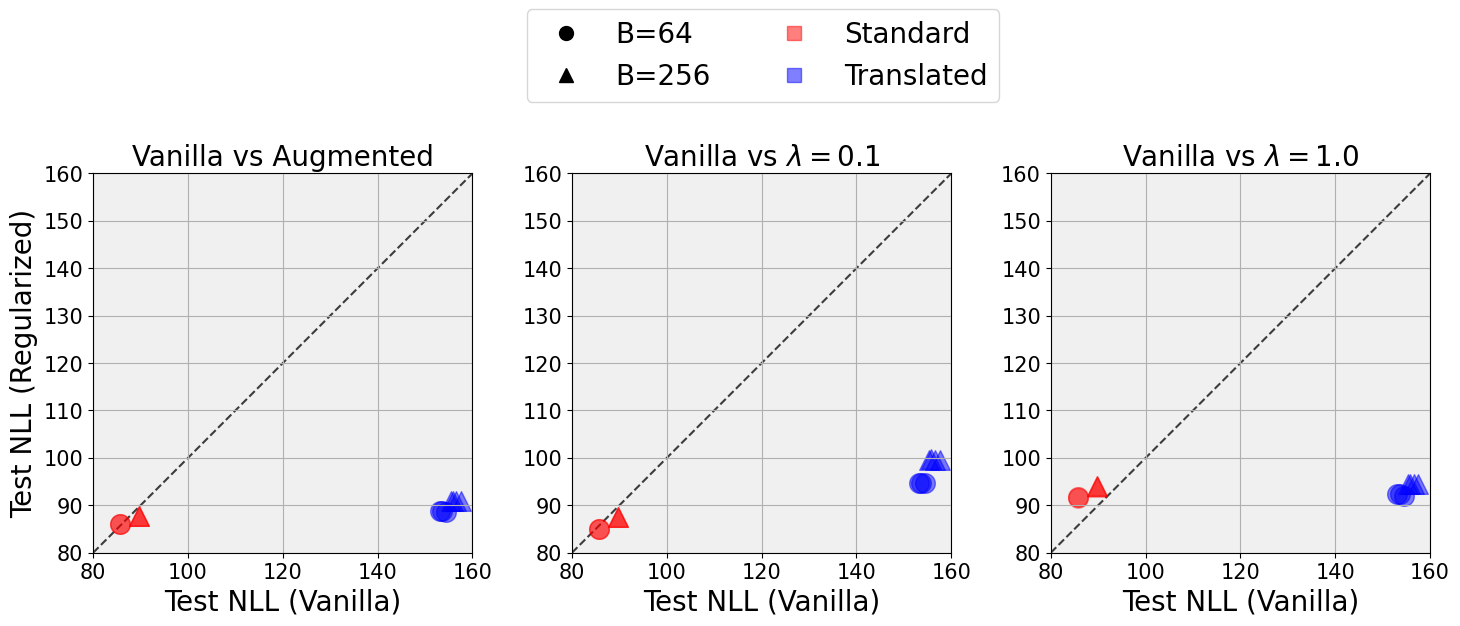

In [9]:
# Define the result directory
result_dir = 'results_made'

# Regular expression pattern to match the directory names and extract hyperparameters
pattern = re.compile(
    r"(?P<datetime>\d{8}_\d{6})_"
    r"S(?P<seed>\d+)_"
    r"E(?P<num_epochs>\d+)_"
    r"BS(?P<batch_size>\d+)_"
    r"LR(?P<lr>[\de.-]+)_"
    r"NM(?P<n_masks>\d+)_"
    r"HL(?P<M>\d+)_"
    r"ID(?P<input_dim>\d+)_"
    r"(?P<data>[^_]+)_"
    r"BIN_"
    r"LAM(?P<lam>[\de.-]+)_"
    r"PAT(?P<patience>\d+)"
    r"(?:_AUG)?(?:_MOD)?"
)

directories = os.listdir(result_dir)
data_dict = defaultdict(lambda: defaultdict(dict))

# Extract nll_val from directories and organize by batch_size and lam
for directory in directories:
    match = pattern.match(directory)
    if match:
        params = match.groupdict()
        batch_size = int(params['batch_size'])
        lam = float(params['lam'])
        if batch_size in [64, 256] and lam in [-1.0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]:
            results_path = os.path.join(result_dir, directory, 'results.json')
            if os.path.exists(results_path):
                with open(results_path, 'r') as f:
                    results = json.load(f)
                    test_nll = results.get('test_val')
                    aug_test_nll = results.get('aug_test_val')
                    nll_val = results.get('nll_val')
                    if test_nll is not None and aug_test_nll is not None:
                        seed = int(params['seed'])
                        data_dict[batch_size][lam][seed] = (test_nll, aug_test_nll, nll_val)

plt.rcParams.update({
    'font.size': 20,          # Global font size
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 20,     # X and Y axis labels font size
    'xtick.labelsize': 15,    # X-axis tick labels font size
    'ytick.labelsize': 15,    # Y-axis tick labels font size
    'legend.fontsize': 20,    # Legend font size
})
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

# Define colors for standard and augmented results
color_standard = 'red'
color_augmented = 'blue'

# Create scatter plots in a 1x2 grid
fig1, axs1 = plt.subplots(1, 3, figsize=(15, 7))

batch_sizes = [64, 256]
lams = [-1.0, 0.1, 1.0]
markers = ['o', '^']  # Different markers for different batch sizes ('o' for 64, '^' for 256)

# Determine global limits for all subplots
all_nll = []
for batch_size in batch_sizes:
    for lam in lams:
        for seed in data_dict[batch_size][lam].keys():
            test_nll, aug_test_nll, _ = data_dict[batch_size][lam][seed]
            all_nll.append(test_nll)
            all_nll.append(aug_test_nll)
global_min = 80  # You can uncomment the next line if you want to determine min dynamically
# global_min = min(all_nll)
global_max = 160  # You can uncomment the next line if you want to determine max dynamically
# global_max = max(all_nll)

# Plot for each lambda value
for j, lam in enumerate(lams):
    ax = axs1[j]
    for i, batch_size in enumerate(batch_sizes):
        seeds = set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys())
        for seed in seeds:
            test_nll_0, aug_test_nll_0, _ = data_dict[batch_size][0][seed]
            test_nll_lam, aug_test_nll_lam, _ = data_dict[batch_size][lam][seed]
            # Transparent for standard
            ax.scatter(test_nll_0, test_nll_lam, color=color_standard, marker=markers[i], s=200, label=f'Seed {seed} (B={batch_size})', alpha = 0.3)
            # Opaque for augmented
            ax.scatter(aug_test_nll_0, aug_test_nll_lam, color=color_augmented, marker=markers[i], s=200, alpha = 0.5)
    if lam == -1:
        ax.set_title(f'Vanilla vs Augmented')
    else:
        ax.set_title(f'Vanilla vs $\\lambda = {lam}$')
    ax.set_facecolor('#f0f0f0')
    ax.set_xlabel('Test NLL (Vanilla)')
    if j == 0:
        ax.set_ylabel('Test NLL (Regularized)')
    else:
        ax.set_ylabel('')
    # Add y=x dashed line
    lims = [global_min, global_max]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(True)

# Create a single legend for all plots
handles = [
    plt.Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=10, label='B=64'),
    plt.Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=10, label='B=256'),
    plt.Line2D([0], [0], marker='s', color=color_standard, linestyle='None', markersize=10, label='Standard', alpha = 0.5),
    plt.Line2D([0], [0], marker='s', color=color_augmented, linestyle='None', markersize=10, label='Translated', alpha = 0.5)
]
fig1.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.522, 1.0))
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot as an SVG file
plt.savefig('images/made/test_scatter_made_mnist.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


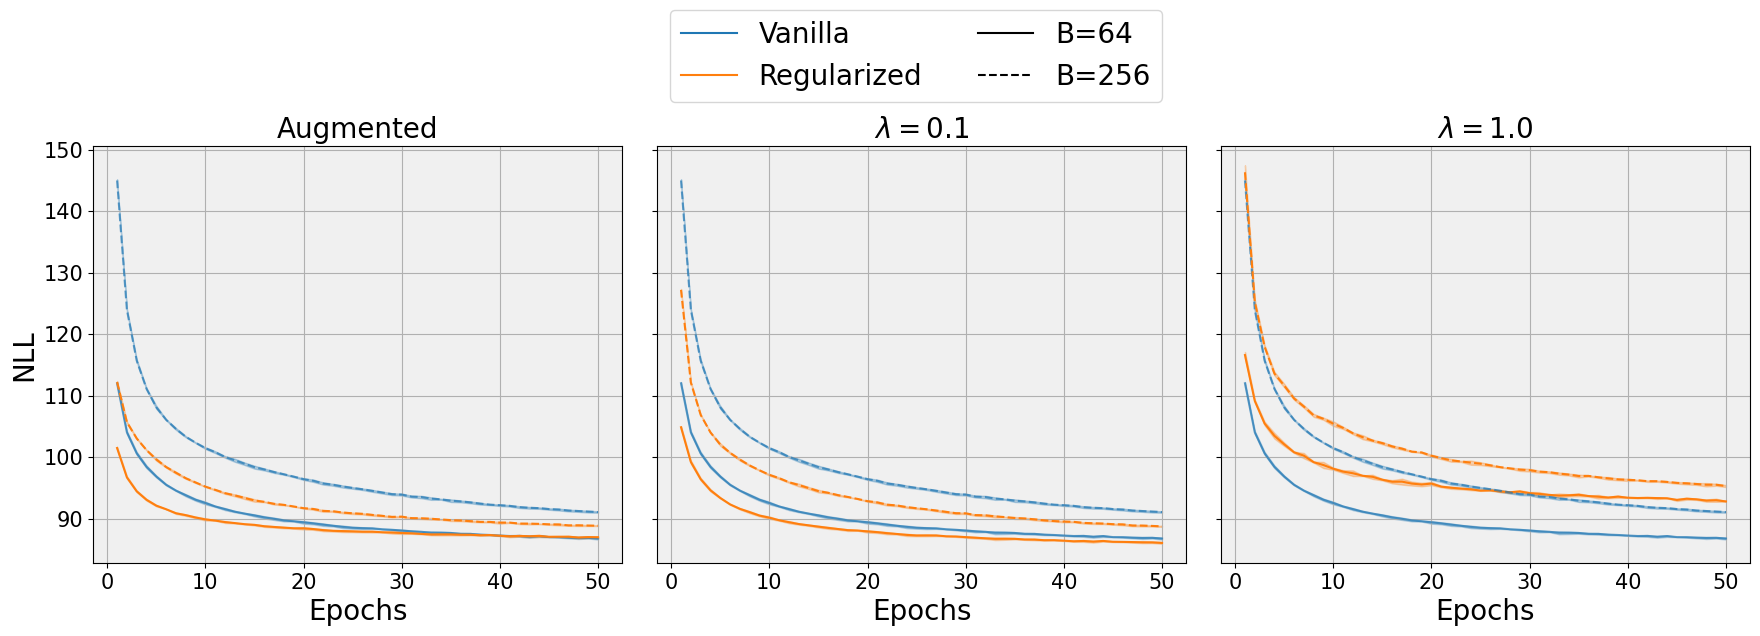

In [10]:
# Function to calculate mean and standard deviation across seeds
def get_mean_and_std(data_dict, batch_size, lam, epochs):
    nll_vals = np.array([data_dict[batch_size][lam][seed][2] for seed in data_dict[batch_size][lam]])
    mean = np.mean(nll_vals, axis=0)
    std = np.std(nll_vals, axis=0)
    return mean, std

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

batch_sizes = [64, 256]
lams = [-1.0, 0.1, 1.0]
colors = ['#1f77b4', '#ff7f0e']  # Blue for Vanilla, Orange for Regularized

for j, lam in enumerate(lams):
    ax = axs2[j]
    for i, batch_size in enumerate(batch_sizes):
        seeds = sorted(set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys()))
        if seeds:
            epochs = len(data_dict[batch_size][0][seeds[0]][2])
            mean_nll_0, std_nll_0 = get_mean_and_std(data_dict, batch_size, 0, epochs)
            mean_nll_lam, std_nll_lam = get_mean_and_std(data_dict, batch_size, lam, epochs)
            
            # Plot mean and fill between mean ± std for vanilla (lambda = 0)
            ax.plot(range(1, epochs + 1), mean_nll_0, color=colors[0], linestyle='--' if batch_size == 256 else '-', alpha=0.7, label=f'Vanilla (B={batch_size})' if lam == 0 and i == 0 else "")
            ax.fill_between(range(1, epochs + 1), mean_nll_0 - std_nll_0, mean_nll_0 + std_nll_0, color=colors[0], alpha=0.3)
            
            # Plot mean and fill between mean ± std for regularized (lambda > 0)
            ax.plot(range(1, epochs + 1), mean_nll_lam, color=colors[1], linestyle='-' if batch_size == 64 else '--', alpha=1, label=f'Regularized (B={batch_size})' if lam > 0 and i == 0 else "")
            ax.fill_between(range(1, epochs + 1), mean_nll_lam - std_nll_lam, mean_nll_lam + std_nll_lam, color=colors[1], alpha=0.3)
    if lam == -1:
        ax.set_title('Augmented')
    else:
        ax.set_title(f'$\\lambda = {lam}$')
    ax.set_xlabel('Epochs')
    ax.set_facecolor('#f0f0f0')
    if j == 0:
        ax.set_ylabel('NLL')
    else:
        ax.set_ylabel('')
    ax.grid(True)

handles = [
    plt.Line2D([0], [0], color=colors[0], label='Vanilla'),
    plt.Line2D([0], [0], color=colors[1], label='Regularized'),
    plt.Line2D([0], [0], linestyle='-', color='#000000', label='B=64'),
    plt.Line2D([0], [0], linestyle='--', color='#000000', label='B=256')
]
fig2.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.52, 1.1))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/made/val_loss_curve_made_mnist.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [11]:
def compute_bpd(nll, dimensionality=784):
    return nll / (np.log(2) * dimensionality)

relative_errors = []
std_test_nll_means = []
aug_test_nll_means = []
batch_size = 64
for lam in [-1.0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]:
    all_test_nll = []
    all_aug_test_nll = []
    for seed in data_dict[batch_size][lam].keys():
        test_nll, aug_test_nll, _ = data_dict[batch_size][lam][seed]
        all_test_nll.append(test_nll)
        all_aug_test_nll.append(aug_test_nll)
    test_nll_mean = np.mean(all_test_nll)
    std_test_nll_means.append(test_nll_mean)
    test_nll_std = np.std(all_test_nll)
    aug_test_nll_mean = np.mean(all_aug_test_nll)
    aug_test_nll_means.append(aug_test_nll_mean)
    aug_test_nll_std = np.std(all_aug_test_nll)
    
    # Compute BPD
    test_bpd_mean = compute_bpd(test_nll_mean)
    test_bpd_std = compute_bpd(test_nll_std)
    aug_test_bpd_mean = compute_bpd(aug_test_nll_mean)
    aug_test_bpd_std = compute_bpd(aug_test_nll_std)
    
    # Compute relative error
    relative_error = ((aug_test_nll_mean - test_nll_mean) / test_nll_mean) * 100
    relative_errors.append(relative_error)
    
    print(f"Lambda = {lam} (Batch Size = {batch_size})")
    print(f"Standard Test NLL: Mean = {test_nll_mean:.2f}, Std = {test_nll_std:.2f}")
    print(f"Standard Test BPD: Mean = {test_bpd_mean:.4f}, Std = {test_bpd_std:.4f}")
    print(f"Augmented Test NLL: Mean = {aug_test_nll_mean:.2f}, Std = {aug_test_nll_std:.2f}")
    print(f"Augmented Test BPD: Mean = {aug_test_bpd_mean:.4f}, Std = {aug_test_bpd_std:.4f}")
    print(f"Relative Error: {relative_error:.2f}%\n")

Lambda = -1.0 (Batch Size = 64)
Standard Test NLL: Mean = 86.05, Std = 0.05
Standard Test BPD: Mean = 0.1583, Std = 0.0001
Augmented Test NLL: Mean = 88.71, Std = 0.04
Augmented Test BPD: Mean = 0.1632, Std = 0.0001
Relative Error: 3.09%

Lambda = 0 (Batch Size = 64)
Standard Test NLL: Mean = 85.71, Std = 0.03
Standard Test BPD: Mean = 0.1577, Std = 0.0000
Augmented Test NLL: Mean = 153.73, Std = 0.56
Augmented Test BPD: Mean = 0.2829, Std = 0.0010
Relative Error: 79.35%

Lambda = 0.1 (Batch Size = 64)
Standard Test NLL: Mean = 85.06, Std = 0.05
Standard Test BPD: Mean = 0.1565, Std = 0.0001
Augmented Test NLL: Mean = 94.70, Std = 0.05
Augmented Test BPD: Mean = 0.1743, Std = 0.0001
Relative Error: 11.33%

Lambda = 0.2 (Batch Size = 64)
Standard Test NLL: Mean = 85.37, Std = 0.00
Standard Test BPD: Mean = 0.1571, Std = 0.0000
Augmented Test NLL: Mean = 91.94, Std = 0.00
Augmented Test BPD: Mean = 0.1692, Std = 0.0000
Relative Error: 7.69%

Lambda = 0.3 (Batch Size = 64)
Standard Test N

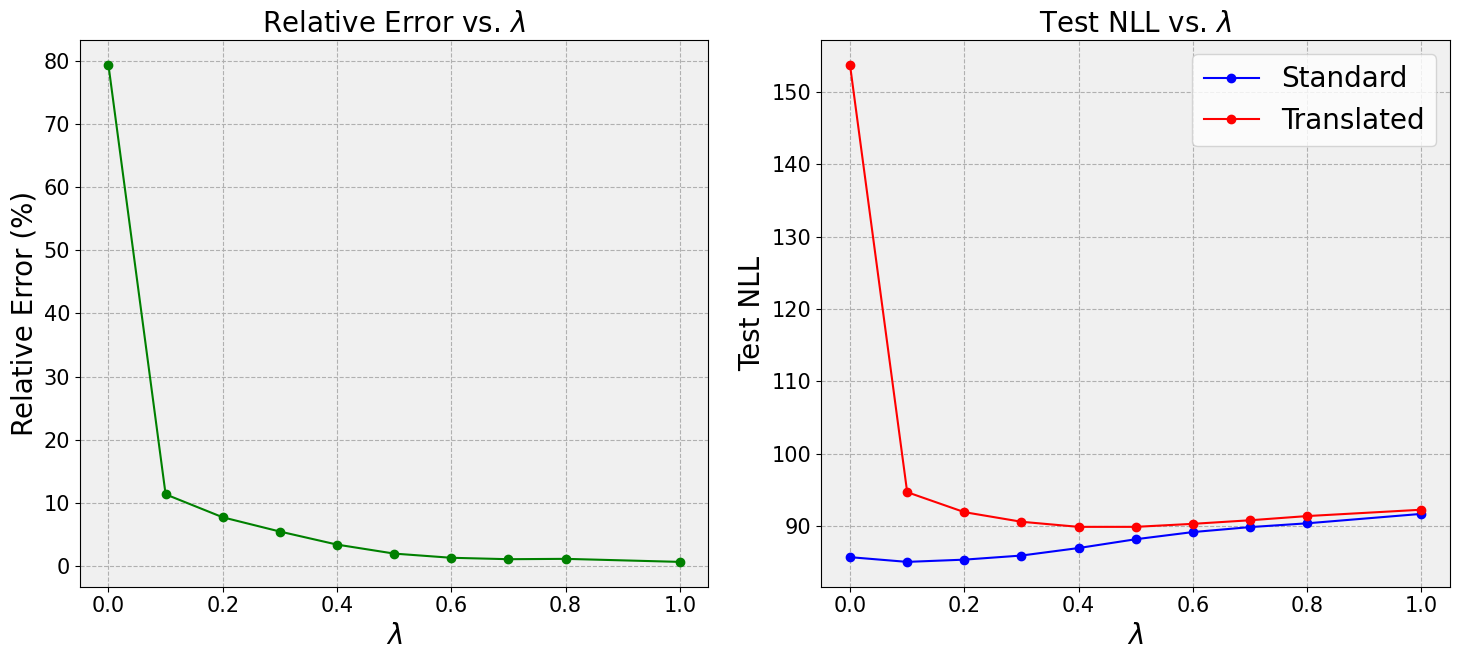

In [12]:
import matplotlib.pyplot as plt
import numpy as np

lams = np.array([-1.0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# First subplot: Relative Error vs. λ
axes[0].plot(lams[1:], relative_errors[1:], marker='o', linestyle='-', color='g', label='Data Points')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Relative Error (%)')
axes[0].set_title('Relative Error vs. $\lambda$')
axes[0].set_facecolor('#f0f0f0')
axes[0].grid(True, which="both", ls="--")

# Second subplot: Test NLL vs. λ
axes[1].plot(lams[1:], std_test_nll_means[1:], marker='o', linestyle='-', color='b', label='Standard')
axes[1].plot(lams[1:], aug_test_nll_means[1:], marker='o', linestyle='-', color='r', label='Translated')
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('Test NLL')
axes[1].set_title('Test NLL vs. $\lambda$')
axes[1].legend(loc='upper right')
axes[1].set_facecolor('#f0f0f0')
axes[1].grid(True, which="both", ls="--")

plt.savefig('images/made/relerrors_mnist_made.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()#rect=[0, 0, 1, 0.95]
plt.show()

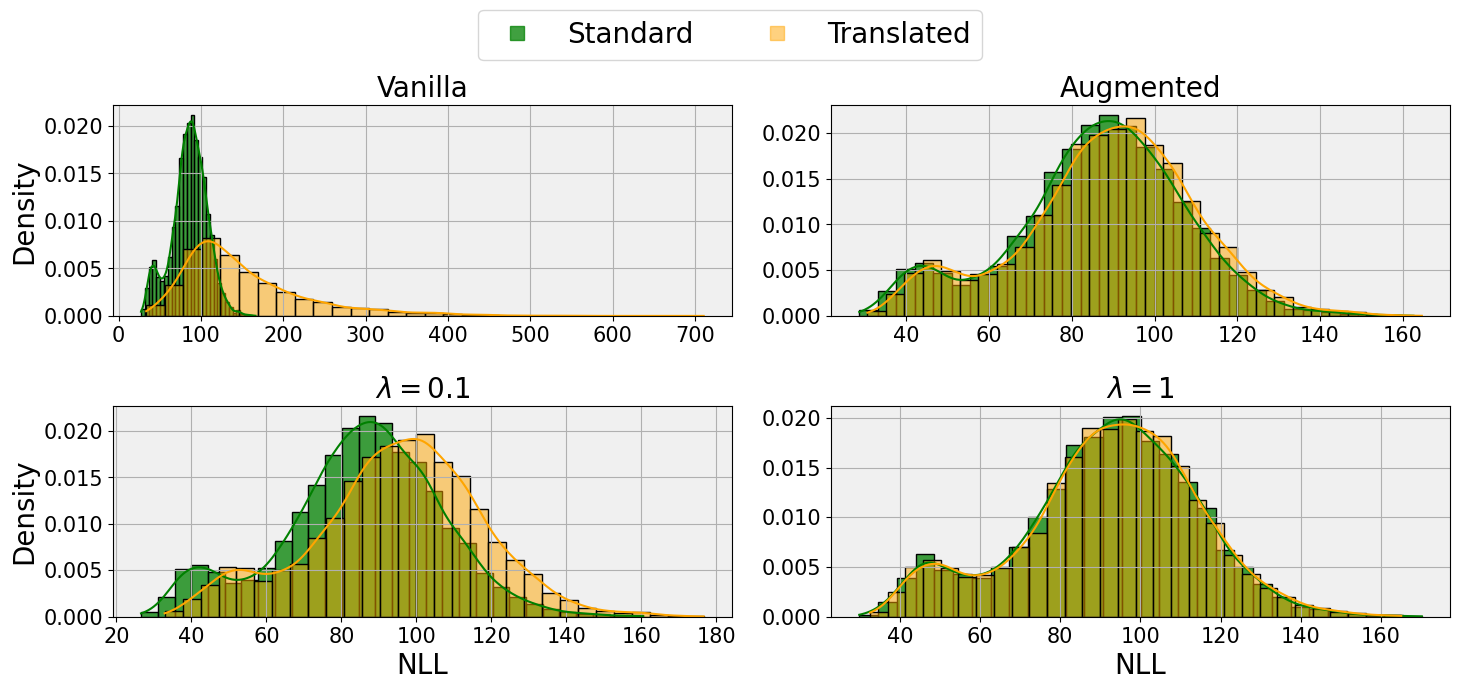

In [13]:
test_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']['mnist']
train_lls_vanilla = eval_dic_vanilla['train_nll_mnist']
test_lls_vanilla_aug = eval_dic_vanilla['aug_nll_mnist']
test_lls_aug = eval_dic_aug['OOD_NLLs_test']['mnist']
train_lls_aug = eval_dic_aug['train_nll_mnist']
test_lls_aug_aug = eval_dic_aug['aug_nll_mnist']
test_lls_regularized = eval_dic_reg['OOD_NLLs_test']['mnist']
train_lls_regularized = eval_dic_reg['train_nll_mnist']
test_lls_regularized_aug = eval_dic_reg['aug_nll_mnist']
test_lls_regularized_plus = eval_dic_reg_plus['OOD_NLLs_test']['mnist']
train_lls_regularized_plus = eval_dic_reg_plus['train_nll_mnist']
test_lls_regularized_plus_aug = eval_dic_reg_plus['aug_nll_mnist']
    
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][0])
sns.histplot(np.array(test_lls_vanilla_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][0])
axs[0][0].set_title('Vanilla')
axs[0][0].set_ylabel('Density')  # Keep y-axis label for the first subplot
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].grid(True)

sns.histplot(np.array(test_lls_aug), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][1])
sns.histplot(np.array(test_lls_aug_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][1])
axs[0][1].set_title('Augmented')
axs[0][1].set_ylabel('')  # Keep y-axis label for the first subplot
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].grid(True)

sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][0])
sns.histplot(np.array(test_lls_regularized_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][0])
axs[1][0].set_title('$\lambda = 0.1$')
axs[1][0].set_xlabel('NLL')
axs[1][0].set_ylabel('Density')  # Remove y-axis label for the second subplot
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].grid(True)

sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][1])
sns.histplot(np.array(test_lls_regularized_plus_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][1])
axs[1][1].set_title('$\lambda = 1$')
axs[1][1].set_xlabel('NLL')
axs[1][1].set_ylabel('')  # Remove y-axis label for the third subplot
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].grid(True)

handles = [
    plt.Line2D([0], [0], linestyle='None', marker='s', color='green', markersize=10, alpha=0.75, label='Standard'),
    plt.Line2D([0], [0], linestyle='None', marker='s', color='orange', markersize=10, alpha=0.5, label='Translated')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/made/aug_hist_made_64.pdf', format='pdf', bbox_inches='tight')
plt.show()

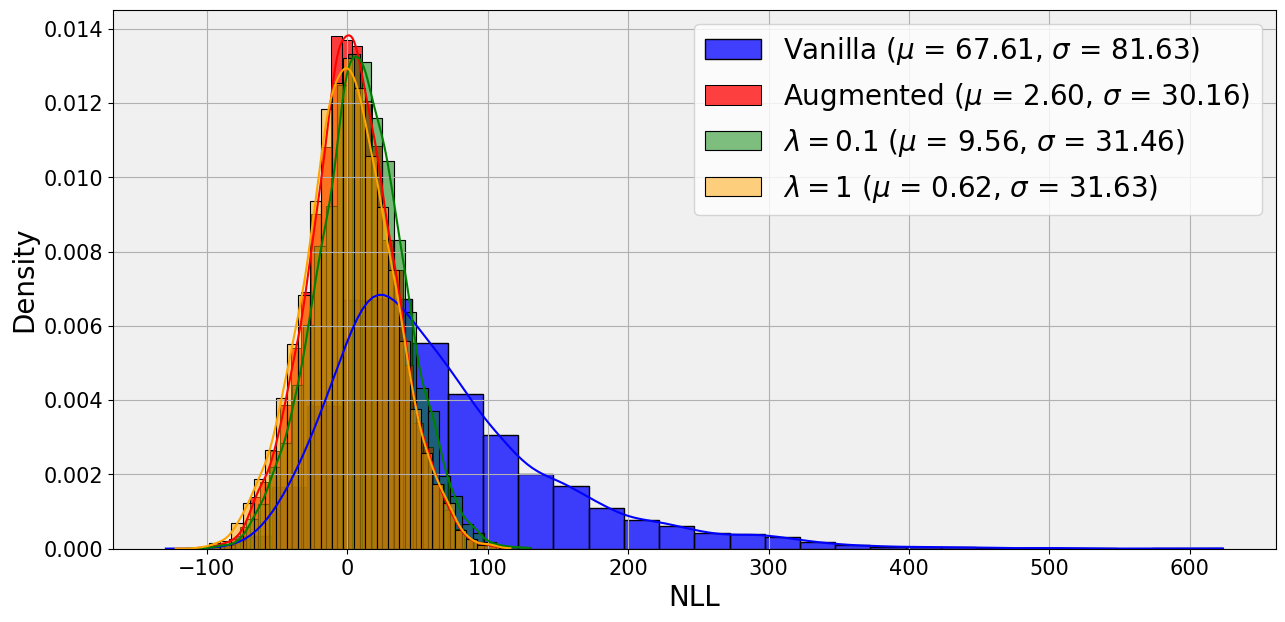

In [14]:
test_diffs_vanilla = np.array(test_lls_vanilla_aug) -  np.array(test_lls_vanilla)
test_diffs_aug =  np.array(test_lls_aug_aug) -  np.array(test_lls_aug)
test_diffs_regularized =  np.array(test_lls_regularized_aug) -  np.array(test_lls_regularized)
test_diffs_regularized_plus =  np.array(test_lls_regularized_plus_aug) -  np.array(test_lls_regularized_plus)

# Calculate means and standard deviations
mean_vanilla = np.mean(test_diffs_vanilla)
std_vanilla = np.std(test_diffs_vanilla)

mean_aug = np.mean(test_diffs_aug)
std_aug = np.std(test_diffs_aug)

mean_regularized = np.mean(test_diffs_regularized)
std_regularized = np.std(test_diffs_regularized)

mean_regularized_plus = np.mean(test_diffs_regularized_plus)
std_regularized_plus = np.std(test_diffs_regularized_plus)

# Create plot
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(test_diffs_vanilla, bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs,
             label=f'Vanilla ($\\mu$ = {mean_vanilla:.2f}, $\\sigma$ = {std_vanilla:.2f})')
sns.histplot(test_diffs_aug, bins=30, stat='density', kde=True, color='red', alpha=0.75, ax=axs,
             label=f'Augmented ($\\mu$ = {mean_aug:.2f}, $\\sigma$ = {std_aug:.2f})')
sns.histplot(test_diffs_regularized, bins=30, stat='density', kde=True, color='green', alpha=0.5, ax=axs,
             label=f'$\\lambda = 0.1$ ($\\mu$ = {mean_regularized:.2f}, $\\sigma$ = {std_regularized:.2f})')
sns.histplot(test_diffs_regularized_plus, bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs,
             label=f'$\\lambda = 1$ ($\\mu$ = {mean_regularized_plus:.2f}, $\\sigma$ = {std_regularized_plus:.2f})')

# Set labels and other plot settings
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.set_facecolor('#f0f0f0')
axs.legend()
axs.grid(True)

# Save the plot as an SVG file
plt.savefig('images/made/diff_hist_made_64.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

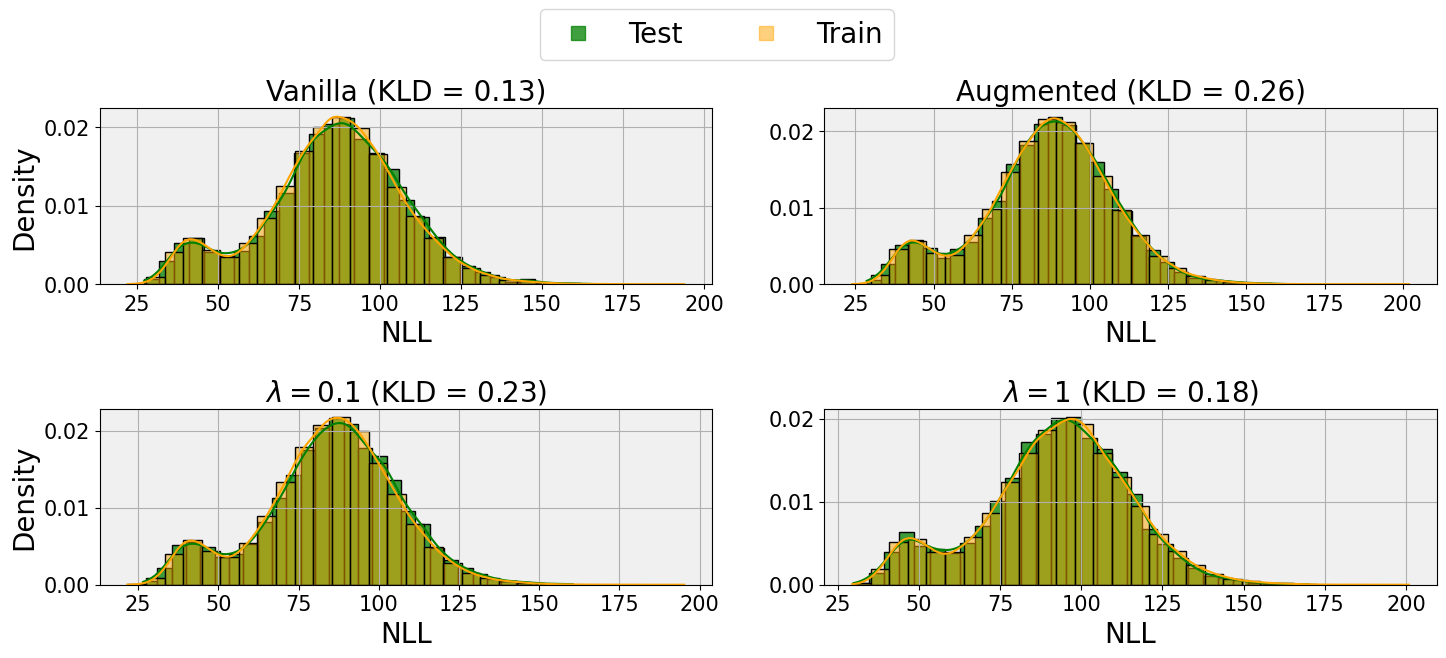

In [15]:
from scipy.stats import entropy

# Function to compute KL divergence
def compute_kl_divergence(train_data, test_data, bins=30):
    train_hist, _ = np.histogram(train_data, bins=bins, density=True)
    test_hist, _ = np.histogram(test_data, bins=bins, density=True)
    # Avoid division by zero by replacing 0 with a small number
    train_hist = np.clip(train_hist, a_min=1e-10, a_max=None)
    test_hist = np.clip(test_hist, a_min=1e-10, a_max=None)
    return entropy(test_hist, train_hist)

# Create the figure with updated size
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

kl_divergence_vanilla = compute_kl_divergence(test_lls_vanilla, train_lls_vanilla)
kl_divergence_aug = compute_kl_divergence(test_lls_aug, train_lls_aug)
kl_divergence_regularized = compute_kl_divergence(test_lls_regularized, train_lls_regularized)
kl_divergence_regularized_plus = compute_kl_divergence(test_lls_regularized_plus, train_lls_regularized_plus)

# Plot for Vanilla
sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][0], label='Test')
sns.histplot(np.array(train_lls_vanilla), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][0], label='Train')
axs[0][0].set_title(f'Vanilla (KLD = {kl_divergence_vanilla:.2f})')
axs[0][0].set_xlabel('NLL')
axs[0][0].set_ylabel('Density')
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].grid(True)

# Plot for Augmented
sns.histplot(np.array(test_lls_aug), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][1], label='Test')
sns.histplot(np.array(train_lls_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][1], label='Train')
axs[0][1].set_title(f'Augmented (KLD = {kl_divergence_aug:.2f})')
axs[0][1].set_xlabel('NLL')
axs[0][1].set_ylabel('')
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].grid(True)

# Plot for Regularized (lambda = 0.1)
sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][0], label='Test')
sns.histplot(np.array(train_lls_regularized), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][0], label='Train')
axs[1][0].set_title(f'$\lambda = 0.1$ (KLD = {kl_divergence_regularized:.2f})')
axs[1][0].set_xlabel('NLL')
axs[1][0].grid(True)
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].set_ylabel('Density')  # Remove redundant y-axis label

# Plot for Regularized (lambda = 1)
sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][1], label='Test')
sns.histplot(np.array(train_lls_regularized_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][1], label='Train')
axs[1][1].set_title(f'$\lambda = 1$ (KLD = {kl_divergence_regularized_plus:.2f})')
axs[1][1].set_xlabel('NLL')
axs[1][1].grid(True)
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].set_ylabel('')  # Remove redundant y-axis label

# Consolidate the legend
handles = [
    plt.Line2D([0], [0], linestyle='None', marker='s', color='green', markersize=10, alpha=0.75, label='Test'),
    plt.Line2D([0], [0], linestyle='None', marker='s', color='orange', markersize=10, alpha=0.5, label='Train')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.975))
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('images/made/train_test_made_64.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Samples

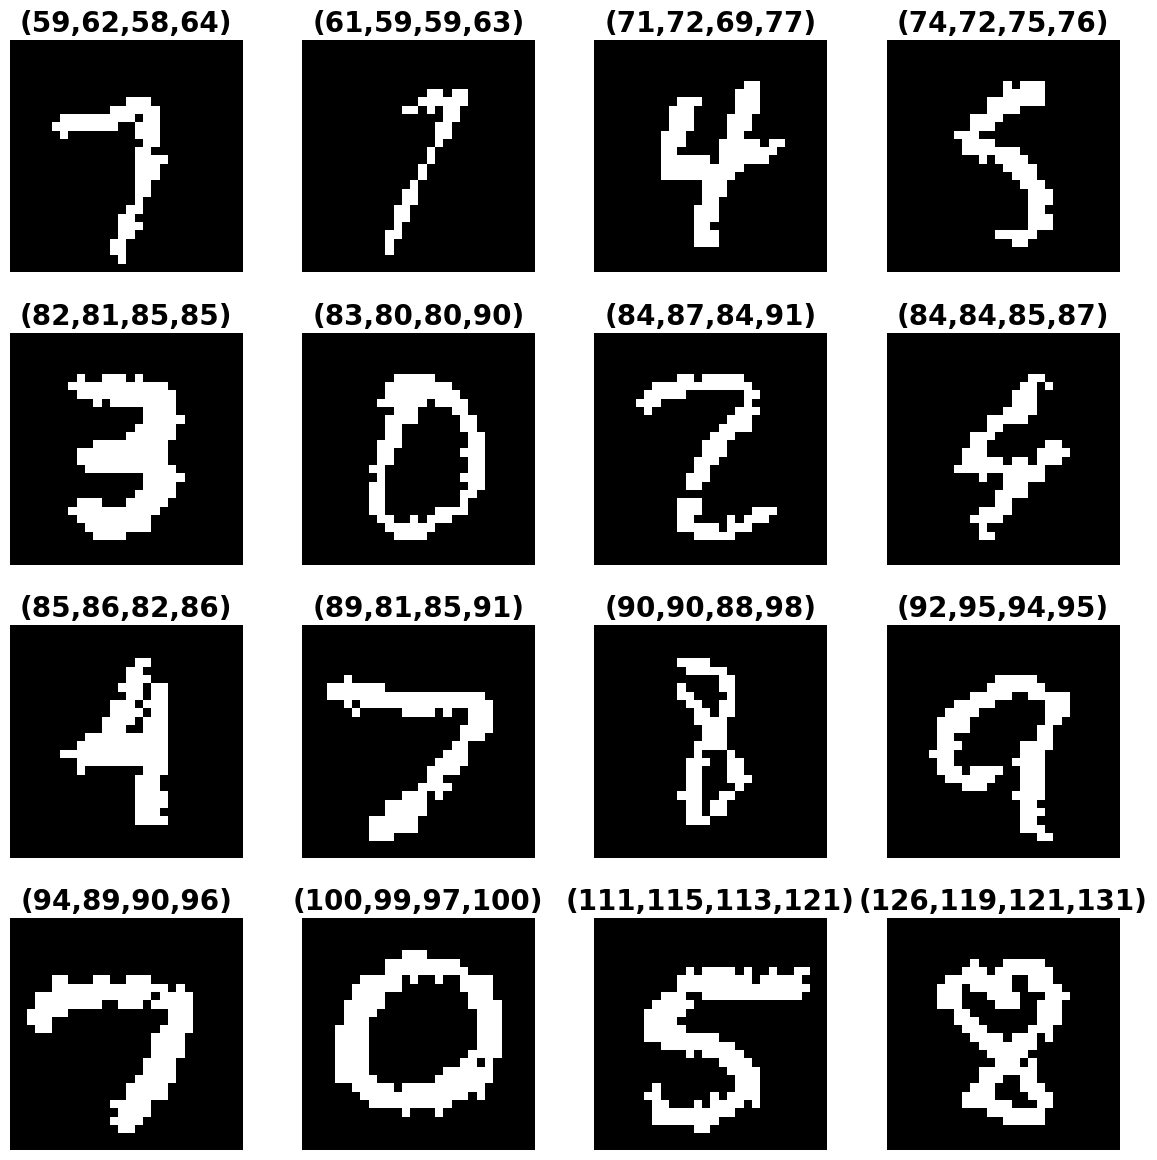

In [16]:
# Collect the images and their NLL values
image_nll_pairs = []
_, _, test_data = load_data('mnist', binarize = True, data_dir = './data')
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

for i, (x, _) in enumerate(test_loader):
    preds_vanilla = model_vanilla.forward(x)
    preds_aug = model_aug.forward(x)
    preds_reg = model_reg.forward(x)
    preds_reg_plus = model_reg_plus.forward(x)
    nll_vanilla = cross_entropy_loss_fn(x, preds_vanilla)
    nll_aug = cross_entropy_loss_fn(x, preds_aug)
    nll_reg = cross_entropy_loss_fn(x, preds_reg)
    nll_reg_plus = cross_entropy_loss_fn(x, preds_reg_plus)
    
    image_nll_pairs.append((x.detach().numpy().reshape(28, 28), nll_vanilla.item(), nll_aug.item(), nll_reg.item(), nll_reg_plus.item()))

    if i >= 15:  # Stop after collecting 100 images
        break

# Sort the images by nll_vanilla values
image_nll_pairs.sort(key=lambda pair: pair[1])

# Plot the sorted images
fig1, axes1 = plt.subplots(4, 4, figsize=(12, 12))

for i, (img, nll_vanilla, nll_aug, nll_reg, nll_reg_plus) in enumerate(image_nll_pairs):
    ax = axes1[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"({round(nll_vanilla)},{round(nll_aug)},{round(nll_reg)},{round(nll_reg_plus)})", fontsize=20, fontweight='bold')
    ax.axis('off')

fig1.tight_layout()
plt.savefig('images/made/samples_made_test.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
plot_samples(model_vanilla, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_vanilla_64.pdf')
plot_samples(model_aug, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_aug_64.pdf')
plot_samples(model_reg, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_reg_64.pdf')
plot_samples(model_reg_plus, 49, model_type = 'MADE', save_dir = 'images/made/samples_made_reg_plus_64.pdf')

# Sample Quality (KID/FID/Precision/Recall)

### KID

In [16]:
kids_vanilla, kid_stats_vanilla = eval_dic_vanilla['KID']['kids'], eval_dic_vanilla['KID']['std']
kids_aug, kid_stats_aug = eval_dic_aug['KID']['kids'], eval_dic_aug['KID']['std']
kids_reg, kid_stats_reg = eval_dic_reg['KID']['kids'], eval_dic_reg['KID']['std']
kids_reg_plus, kid_stats_reg_plus = eval_dic_reg_plus['KID']['kids'], eval_dic_reg_plus['KID']['std']

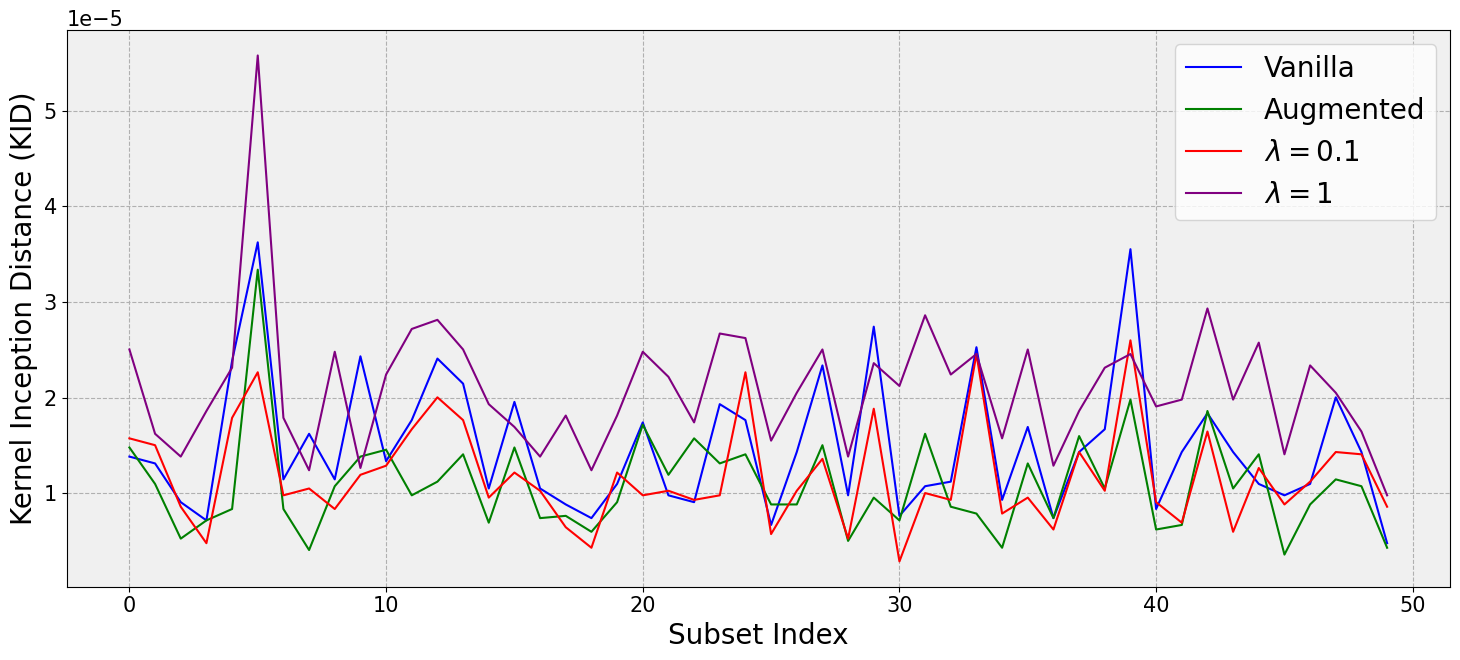

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor('#f0f0f0')
ax.plot(range(len(kids_vanilla)), kids_vanilla, linestyle='-', color='blue', 
        label=f'Vanilla')
ax.plot(range(len(kids_aug)), kids_aug, linestyle='-', color='green', 
        label=f'Augmented')
ax.plot(range(len(kids_reg)), kids_reg, linestyle='-', color='red', 
        label=f'$\lambda = 0.1$')
ax.plot(range(len(kids_reg_plus)), kids_reg_plus, linestyle='-', color='purple', 
        label=f'$\lambda = 1$')

ax.set_xlabel('Subset Index')
ax.set_ylabel('Kernel Inception Distance (KID)')
ax.grid(True, which="both", ls="--")
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('images/made/kids_made_mnist.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [18]:
print(f'Vanilla (mean={kid_stats_vanilla[0]}, std={kid_stats_vanilla[1]})')
print(f'Augmented (mean={kid_stats_aug[0]}, std={kid_stats_aug[1]})')
print(f'$\lambda=0.1$ (mean={kid_stats_reg[0]}, std={kid_stats_reg[1]})')
print(f'$\lambda=1$ (mean={kid_stats_reg_plus[0]}, std={kid_stats_reg_plus[1]})')

Vanilla (mean=1.4934539649402723e-05, std=6.964558906474849e-06)
Augmented (mean=1.086235079128528e-05, std=5.130413683218649e-06)
$\lambda=0.1$ (mean=1.1830329640361015e-05, std=5.254064035398187e-06)
$\lambda=1$ (mean=2.104282430082094e-05, std=6.994700470386306e-06)


### Precision and Recall

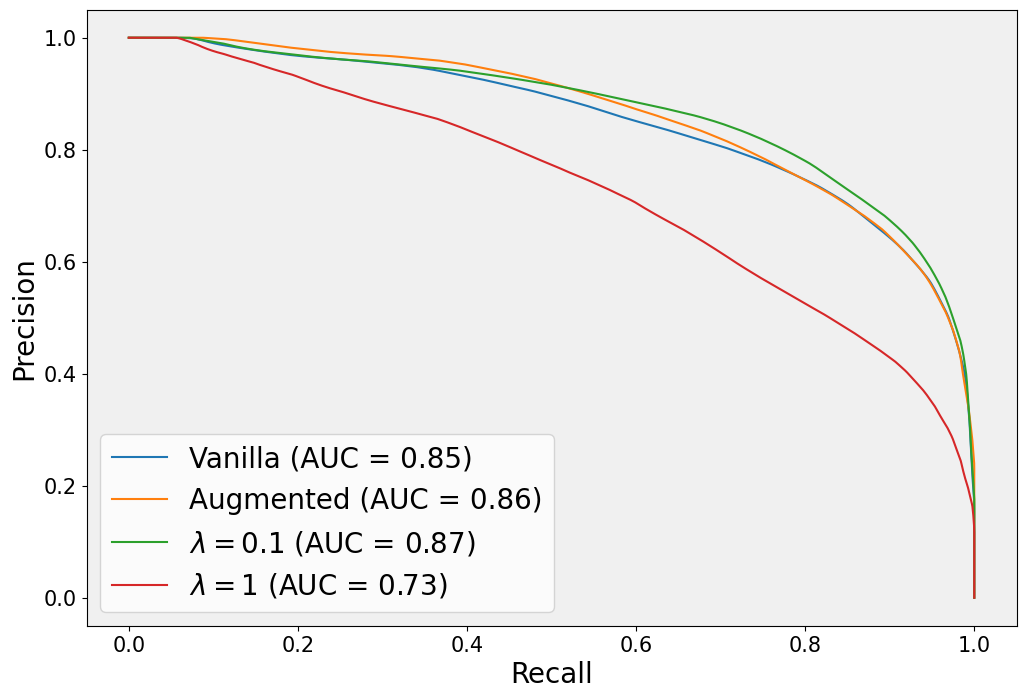

In [19]:
prd_vanilla = eval_dic_vanilla['PRD']
precisions_vanilla, recalls_vanilla = prd_vanilla['precisions'], prd_vanilla['recalls']
prd_aug = eval_dic_aug['PRD']
precisions_aug, recalls_aug = prd_aug['precisions'], prd_aug['recalls']
prd_reg = eval_dic_reg['PRD']
precisions_reg, recalls_reg = prd_reg['precisions'], prd_reg['recalls']
prd_reg_plus = eval_dic_reg_plus['PRD']
precisions_reg_plus, recalls_reg_plus = prd_reg_plus['precisions'], prd_reg_plus['recalls']
auc_vanilla = np.trapz(recalls_vanilla, precisions_vanilla)
auc_aug = np.trapz(recalls_aug, precisions_aug)
auc_reg = np.trapz(recalls_reg, precisions_reg)
auc_reg_plus = np.trapz(recalls_reg_plus, precisions_reg_plus)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(precisions_vanilla, recalls_vanilla, label=f'Vanilla (AUC = {auc_vanilla:.2f})')
ax.plot(precisions_aug, recalls_aug, label=f'Augmented (AUC = {auc_aug:.2f})')
ax.plot(precisions_reg, recalls_reg, label=f'$\lambda = 0.1$ (AUC = {auc_reg:.2f})')
ax.plot(precisions_reg_plus, recalls_reg_plus, label=f'$\lambda = 1$ (AUC = {auc_reg_plus:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_facecolor('#f0f0f0')
ax.legend(loc='best')
plt.savefig('images/made/pr_curve_mnist_made.pdf', format='pdf', bbox_inches='tight')
plt.show()

# OOD Detection

### ROC/AUC

In [40]:
#roc_pc_vanilla = eval_dic_vanilla['roc_pc']
#fpr_vanilla, tpr_vanilla, roc_auc_vanilla, recall_vanilla, precision_vanilla, pr_auc_vanilla \
#    = roc_pc_vanilla['fpr'], roc_pc_vanilla['tpr'], roc_pc_vanilla['roc_auc'], roc_pc_vanilla['recall'], \
#    roc_pc_vanilla['precision'], roc_pc_vanilla['pr_auc']
#roc_pc_aug = eval_dic_aug['roc_pc']
#fpr_aug, tpr_aug, roc_auc_aug, recall_aug, precision_aug, pr_auc_aug \
#    = roc_pc_aug['fpr'], roc_pc_aug['tpr'], roc_pc_aug['roc_auc'], roc_pc_aug['recall'], \
#    roc_pc_aug['precision'], roc_pc_aug['pr_auc']
#roc_pc_reg = eval_dic_reg['roc_pc']
#fpr_reg, tpr_reg, roc_auc_reg, recall_reg, precision_reg, pr_auc_reg = roc_pc_reg['fpr'], roc_pc_reg['tpr'], \
#    roc_pc_reg['roc_auc'], roc_pc_reg['recall'], roc_pc_reg['precision'], roc_pc_reg['pr_auc']
#roc_pc_reg_plus = eval_dic_reg_plus['roc_pc']
#fpr_reg_plus, tpr_reg_plus, roc_auc_reg_plus, recall_reg_plus, precision_reg_plus, pr_auc_reg_plus = roc_pc_reg_plus['fpr'], \
#    roc_pc_reg_plus['tpr'], roc_pc_reg_plus['roc_auc'], roc_pc_reg_plus['recall'], roc_pc_reg_plus['precision'], roc_pc_reg_plus['pr_auc']

from util import roc_pc
from data import load_data
train_data, _, test_data = load_data('mnist', data_dir = './data', binarize = False, val = False)
test_loader = DataLoader(test_data, batch_size=1, shuffle = True)
_, _, test_data_emnist = load_data('emnist', data_dir = './data', binarize = False, val = False)
test_loader_emnist = DataLoader(test_data_emnist, batch_size=1, shuffle = False)

ood_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']
test_lls_mnist_vanilla, test_lls_emnist_vanilla = ood_lls_vanilla['mnist'], ood_lls_vanilla['emnist']
ood_lls_aug = eval_dic_aug['OOD_NLLs_test']
test_lls_mnist_aug, test_lls_emnist_aug = ood_lls_aug['mnist'], ood_lls_aug['emnist']
ood_lls_reg = eval_dic_reg['OOD_NLLs_test']
test_lls_mnist_reg, test_lls_emnist_reg = ood_lls_reg['mnist'], ood_lls_reg['emnist']
ood_lls_reg_plus = eval_dic_reg_plus['OOD_NLLs_test']
test_lls_mnist_reg_plus, test_lls_emnist_reg_plus = ood_lls_reg_plus['mnist'], ood_lls_reg_plus['emnist']

fpr_vanilla, tpr_vanilla, thresholds_vanilla, roc_auc_vanilla, precision_vanilla, recall_vanilla, pr_thresholds_vanilla, pr_auc_vanilla, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_emnist, \
model = model_vanilla, model_type = 'MADE', nll_mnist = np.array(test_lls_mnist_vanilla), nll_ood = np.array(test_lls_emnist_vanilla))

fpr_aug, tpr_aug, thresholds_aug, roc_auc_aug, precision_aug, recall_aug, pr_thresholds_aug, pr_auc_aug, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_emnist, \
model = model_aug, model_type = 'MADE', nll_mnist = np.array(test_lls_mnist_aug), nll_ood = np.array(test_lls_emnist_aug))

fpr_reg, tpr_reg, thresholds_reg, roc_auc_reg, precision_reg, recall_reg, pr_thresholds_reg, pr_auc_reg, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_emnist, \
model = model_reg, model_type = 'MADE', nll_mnist = np.array(test_lls_mnist_reg), nll_ood = np.array(test_lls_emnist_reg))

fpr_reg_plus, tpr_reg_plus, thresholds_reg_plus, roc_auc_reg_plus, precision_reg_plus, recall_reg_plus, pr_thresholds_reg_plus, pr_auc_reg_plus, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_emnist, \
model = model_reg_plus, model_type = 'MADE', nll_mnist = np.array(test_lls_mnist_reg_plus), nll_ood = np.array(test_lls_emnist_reg_plus))

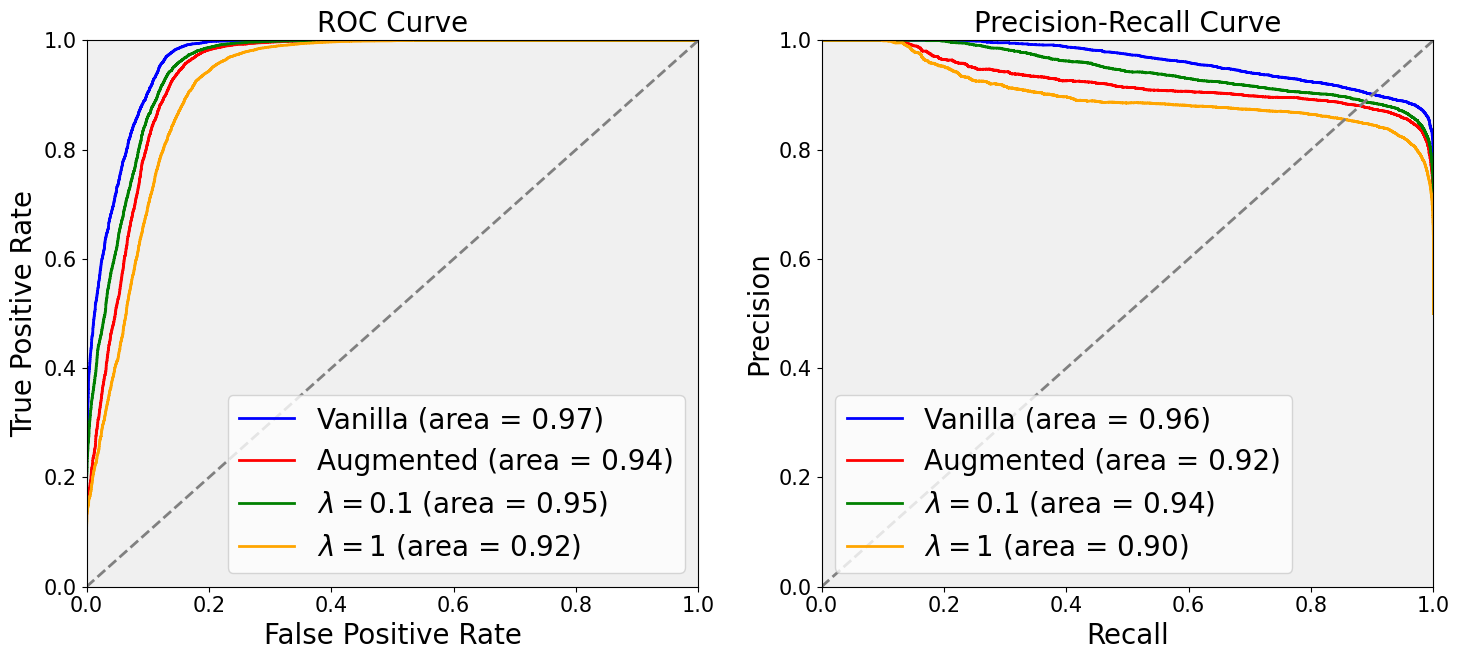

In [41]:
# Create a figure with 1 row and 2 columns for the subplots
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(15, 7))

# Set the face color for both subplots
ax_roc.set_facecolor('#f0f0f0')
ax_pr.set_facecolor('#f0f0f0')

# Plot the ROC curves in the first subplot
ax_roc.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'Vanilla (area = {roc_auc_vanilla:.2f})')
ax_roc.plot(fpr_aug, tpr_aug, color='red', lw=2, label=f'Augmented (area = {roc_auc_aug:.2f})')
ax_roc.plot(fpr_reg, tpr_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {roc_auc_reg:.2f})')
ax_roc.plot(fpr_reg_plus, tpr_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {roc_auc_reg_plus:.2f})')
ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.0])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve')
ax_roc.legend(loc="lower right")

# Plot the Precision-Recall curves in the second subplot
ax_pr.plot(recall_vanilla, precision_vanilla, color='blue', lw=2, label=f'Vanilla (area = {pr_auc_vanilla:.2f})')
ax_pr.plot(recall_aug, precision_aug, color='red', lw=2, label=f'Augmented (area = {pr_auc_aug:.2f})')
ax_pr.plot(recall_reg, precision_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {pr_auc_reg:.2f})')
ax_pr.plot(recall_reg_plus, precision_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {pr_auc_reg_plus:.2f})')
ax_pr.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.0])
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend(loc="lower left")
plt.tight_layout()
plt.savefig('images/made/rocpr_mnist_emnist_made.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Typicality

0.12974588089271227
0.12974588089271227
0.12974588089271227
0.1060749465058228
0.12800089423557443
0.1222375015943962


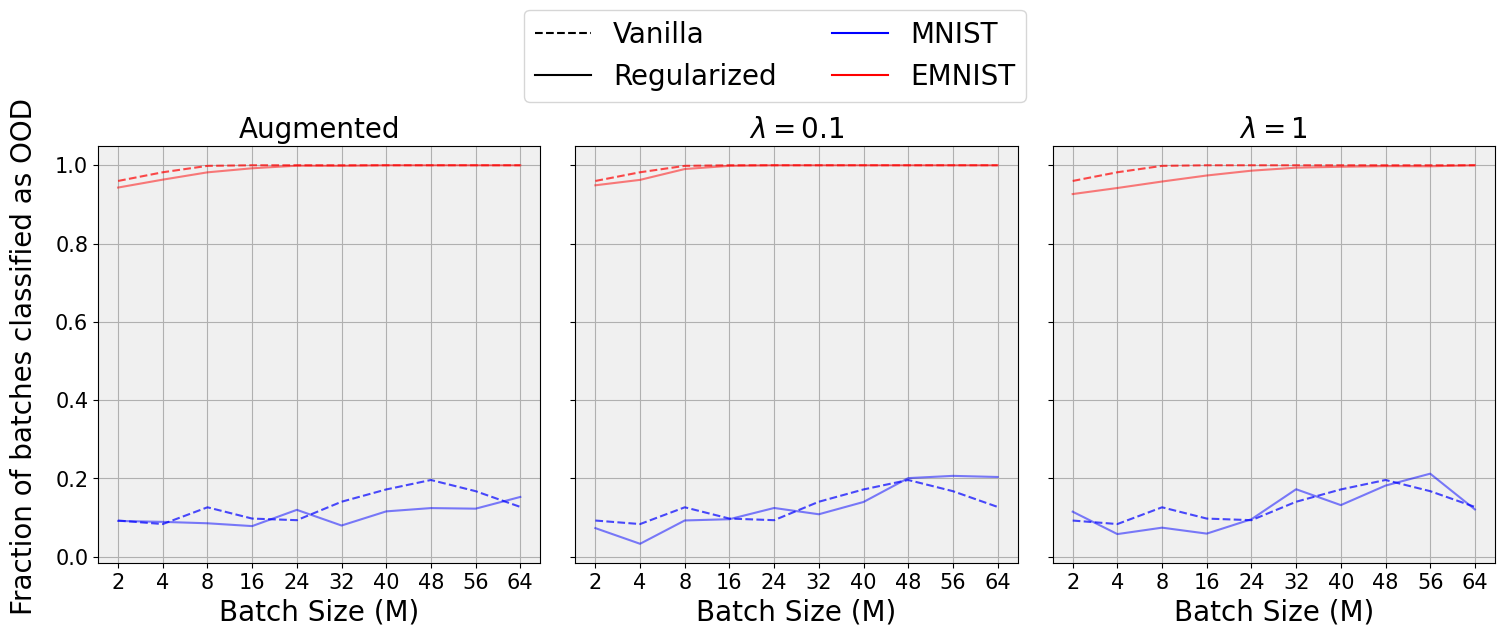

In [53]:
data_vanilla = eval_dic_vanilla['typicality']
data_aug = eval_dic_aug['typicality']
data_reg = eval_dic_reg['typicality']
data_reg_plus = eval_dic_reg_plus['typicality']

datasets = {
    'Augmented': data_aug,
    '$\lambda=0.1$': data_reg,
    '$\lambda=1$': data_reg_plus
}

fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Plotting the Vanilla model as a common dashed line in each subplot
for ax in axs:
    M_values_vanilla = list(data_vanilla.keys())
    mnist_values_vanilla = [data_vanilla[m]['mnist'] for m in M_values_vanilla]
    emnist_values_vanilla = [data_vanilla[m]['emnist'] for m in M_values_vanilla]
    M_values_vanilla = [m.split('=')[1] for m in M_values_vanilla]
    print(np.mean(mnist_values_vanilla))
    ax.plot(M_values_vanilla, mnist_values_vanilla, linestyle='--', color='blue', alpha=0.7)
    ax.plot(M_values_vanilla, emnist_values_vanilla, linestyle='--', color='red', alpha=0.7)

# Plotting the other models
for i, (ax, (label, data)) in enumerate(zip(axs, datasets.items())):
    M_values = list(data.keys())
    mnist_values = [data[m]['mnist'] for m in M_values]
    emnist_values = [data[m]['emnist'] for m in M_values]
    M_values = [m.split('=')[1] for m in M_values]
    print(np.mean(mnist_values))
    ax.plot(M_values, mnist_values, linestyle='-', color='blue', alpha=0.5)
    ax.plot(M_values, emnist_values, linestyle='-', color='red', alpha=0.5)
    ax.set_xlabel('Batch Size (M)')
    ax.set_title(f'{label}')
    ax.grid(True)
    ax.set_facecolor('#f0f0f0')

# Custom legend
handles = [
    plt.Line2D([0], [0], linestyle='--', color='black', label='Vanilla'),
    plt.Line2D([0], [0], linestyle='-', color='black', label='Regularized'),
    plt.Line2D([0], [0], linestyle='-', color='blue', label='MNIST'),
    plt.Line2D([0], [0], linestyle='-', color='red', label='EMNIST')
]

fig.text(-0.01, 0.5, 'Fraction of batches classified as OOD', va='center', rotation='vertical')
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make space for the legend
plt.savefig('images/made/ood_mnist_emnist_typicality_95.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Visualization

In [49]:
ood_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']
test_lls_mnist_vanilla, test_lls_emnist_vanilla = ood_lls_vanilla['mnist'], ood_lls_vanilla['emnist']
ood_lls_aug = eval_dic_aug['OOD_NLLs_test']
test_lls_mnist_aug, test_lls_emnist_aug = ood_lls_aug['mnist'], ood_lls_aug['emnist']
ood_lls_reg = eval_dic_reg['OOD_NLLs_test']
test_lls_mnist_reg, test_lls_emnist_reg = ood_lls_reg['mnist'], ood_lls_reg['emnist']
ood_lls_reg_plus = eval_dic_reg_plus['OOD_NLLs_test']
test_lls_mnist_reg_plus, test_lls_emnist_reg_plus = ood_lls_reg_plus['mnist'], ood_lls_reg_plus['emnist']

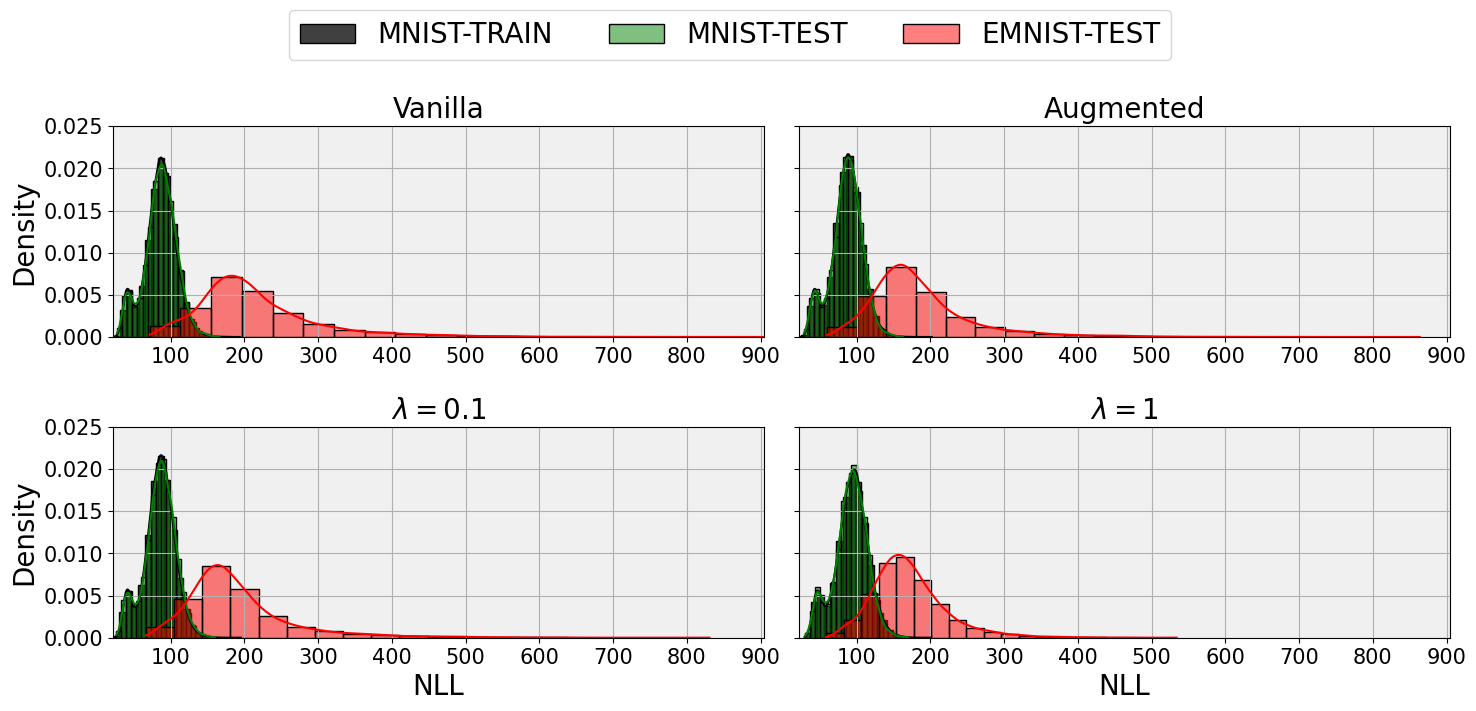

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_lls_vanilla, test_lls_mnist_vanilla, test_lls_emnist_vanilla, etc. are defined

fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True)

# Define the x and y limits based on your data
x_min = min(np.min(train_lls_vanilla), np.min(test_lls_mnist_vanilla), np.min(test_lls_emnist_vanilla),
            np.min(train_lls_aug), np.min(test_lls_mnist_aug), np.min(test_lls_emnist_aug),
            np.min(train_lls_regularized), np.min(test_lls_mnist_reg), np.min(test_lls_emnist_reg),
            np.min(train_lls_regularized_plus), np.min(test_lls_mnist_reg_plus), np.min(test_lls_emnist_reg_plus))
x_max = max(np.max(train_lls_vanilla), np.max(test_lls_mnist_vanilla), np.max(test_lls_emnist_vanilla),
            np.max(train_lls_aug), np.max(test_lls_mnist_aug), np.max(test_lls_emnist_aug),
            np.max(train_lls_regularized), np.max(test_lls_mnist_reg), np.max(test_lls_emnist_reg),
            np.max(train_lls_regularized_plus), np.max(test_lls_mnist_reg_plus), np.max(test_lls_emnist_reg_plus))

y_min = 0  # Density plots should start from 0
y_max = 0.025  # Adjust this based on your specific data range

# Vanilla (lambda = 0)
sns.histplot(train_lls_vanilla, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[0][0], label='MNIST-TRAIN')
sns.histplot(test_lls_mnist_vanilla, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[0][0], label='MNIST-TEST')
sns.histplot(test_lls_emnist_vanilla, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[0][0], label='EMNIST-TEST')
axs[0][0].set_title('Vanilla')
axs[0][0].set_ylabel('Density')
axs[0][0].grid(True)
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].set_xlim(x_min, x_max)
axs[0][0].set_ylim(y_min, y_max)

# Augmented
sns.histplot(train_lls_aug, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[0][1])
sns.histplot(test_lls_mnist_aug, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[0][1])
sns.histplot(test_lls_emnist_aug, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[0][1])
axs[0][1].set_title('Augmented')
axs[0][1].grid(True)
axs[0][1].set_ylabel('')
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].set_xlim(x_min, x_max)
axs[0][1].set_ylim(y_min, y_max)

# Regularized (lambda = 0.1)
sns.histplot(train_lls_regularized, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[1][0])
sns.histplot(test_lls_mnist_reg, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[1][0])
sns.histplot(test_lls_emnist_reg, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[1][0])
axs[1][0].set_title(r'$\lambda = 0.1$')
axs[1][0].set_xlabel('NLL')
axs[1][0].set_ylabel('Density')
axs[1][0].grid(True)
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].set_xlim(x_min, x_max)
axs[1][0].set_ylim(y_min, y_max)

# Regularized Plus (lambda = 1)
sns.histplot(train_lls_regularized_plus, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[1][1])
sns.histplot(test_lls_mnist_reg_plus, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[1][1])
sns.histplot(test_lls_emnist_reg_plus, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[1][1])
axs[1][1].set_title(r'$\lambda = 1$')
axs[1][1].set_xlabel('NLL')
axs[1][1].grid(True)
axs[1][1].set_ylabel('')
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].set_xlim(x_min, x_max)
axs[1][1].set_ylim(y_min, y_max)

# Combine the legends into one at the top
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/made/ood_histograms_mnist_emnist_made.pdf', format='pdf', bbox_inches='tight')

plt.show()
